In [12]:
import pandas as pd
import matplotlib.pyplot as plt#MODULE NAME
import os
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.exposure as exposure
import pandas as pd
import numpy as np
import subprocess
import snappy
import imageio
import rasterio as rio
import rasterstats as rs
import rasterio.plot 
from glob import iglob
import geopandas as gpd
from pyspatialml import Raster
import seaborn as sns
from rasterio.plot import show
get_ipython().run_line_magic('matplotlib', 'inline')
from osgeo import gdal
import prosail
from prosail import spectral_lib
import numpy as np
import numpy.matlib
import numpy as np
from numpy.random import seed
from numpy.random import rand
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
#Installing packages

#Needed for step 1 - data generation

#Installing PROSAIL
#!pip install prosail

#latin hypercube stuff
#lets try to do a LHS
#!pip install lhsmdu

#this package as a number of functions to deal with hyperspectral data
#!pip install pysptools

#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
import lhsmdu

#package to for operations on spectral data
import pysptools as sptool 
from pysptools import distance
#machine learning packages are imported later, nearer to the model
from numpy.random import seed
from numpy.random import rand
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
with rasterio.open(r'C:\Users\BSibiya\Desktop\PROSAIL-MODEL\sentinel-Image\sentinel_prosail.tif') as src:
    blue = src.read(1, masked=True) #B2
    green = src.read(2, masked=True) #B3
    red = src.read(3, masked=True) #B4
    Red_Edge_1 = src.read(4, masked=True) #B5
    Red_Edge_2 = src.read(5, masked=True) #B6
    Red_Edge_3 = src.read(6, masked=True) #B7
    nir = src.read(7, masked=True) #B8
    Red_Edge4 = src.read(8, masked=True) #B8A
    swir_1 = src.read(9, masked=True) #B11
    swir_2 = src.read(10, masked=True) #B12
    
np.seterr(divide='ignore', invalid='ignore')
VI_output = '/Users/BSibiya/Desktop/PROSAIL-MODEL/VI-output/'


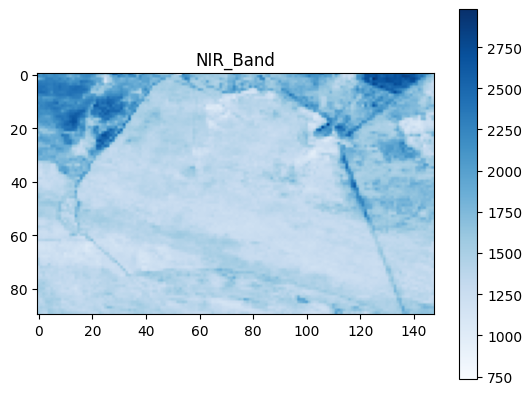

In [15]:
plt.imshow(nir, cmap='Blues')
plt.colorbar()
plt.title('NIR_Band')
plt.show()

In [11]:
dataframe = r'C:\Users\BSibiya\Desktop\PROSAIL-MODEL\datasets\datasets.xlsx'
df = pd.read_excel(dataframe)
df.head()

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,CHLOR
0,955,837,750,953,1331,1498,1515,1752,2318,1397,0.337748
1,903,795,719,924,1296,1437,1466,1680,1968,1215,0.299015
2,855,716,636,828,1150,1336,1372,1556,2035,1141,0.394551
3,859,742,647,853,1250,1412,1438,1657,1978,1106,0.288748
4,842,694,623,771,1078,1231,1265,1437,1886,1067,0.270146


In [44]:
S2_meas = df[['B2', 'B3', 'B4', 'B5','B6', 'B7', 'B8','B8A', 'B11','B12']]
df_chloro = df[['CHLOR']]

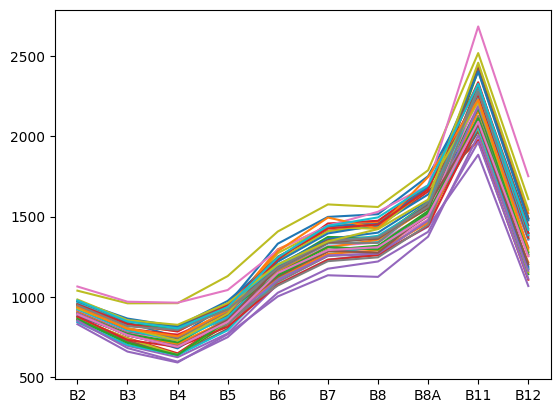

In [8]:
plt.plot(S2_meas.T);

In [55]:
np.random.seed(0)
krange=10000
n=1.28
chloro= 18+rand(krange)*50
caroten=rand(krange)*20
brown=rand(krange)*1
EWT=rand(krange)*0.009
LMA=rand(krange)*0.009
LAI=1+rand(krange)*6
hot_spot=0.1
tts = 25.6800490939937 # solar zenith angle (in degrees)
tto = 0 # sensor/observer zenith angle (in degrees)
psi = 66.2901524550189 # Azimuth angle - difference between sun and sensor (in degrees)
typelidf=1 # Leaf angle distribution type
lidfa = -1 # leaf angle distribution parameter a and b (Spherical)
lidfb=0 # Leaf angle distribution
rsoil = 0,39  # Soil brigthness factor 
psoil = -0,12 # Dry/Wet soil factor

#soilType=pyPro4SAIL.DEFAULT_SOIL
#sal=len(solar_zenith)
#rho=np.zeros((sal,krange,2101))
rho_out = np.zeros((krange,2101))
for i in range(krange):
    rho_out[i,:] = prosail.run_prosail(n,chloro[i],caroten[i],brown[i], EWT[i], LMA[i], LAI[i], lidfa,hot_spot,tts,tto,psi, typelidf=1, lidfb=0,
                                 factor='DHR', rsoil=0.39, psoil=-0.12)


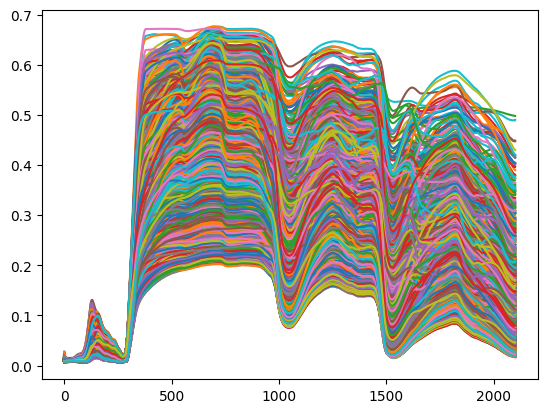

In [56]:
plt.plot(rho_out.T);

In [57]:
#this function also transforms the hyperspectral data to sentinel data
def Prosail2S2(path2csv, spectra_input):
    #importing pandas
    import pandas as pd
    import numpy
    import numpy as np
    
    s2_table = pd.read_csv(path2csv,sep=";",decimal=",") #check if this is proper, regarding the sep and dec
    s2_table_sel = s2_table[s2_table['SR_WL'].between(400,2500)] #selects all values between 400 and 2500
    spectra_input_df = pd.DataFrame(data=spectra_input,columns=["rho"],index=s2_table_sel.index) #transforms the input array into a pandas df with the column name rho and row.index = to the original input table

  
    rho_s2 = s2_table_sel.multiply(spectra_input_df['rho'],axis="index") #calculates the numerator
    w_band_sum = s2_table_sel.sum(axis=0,skipna = True) #calculates the denominator

    output = (rho_s2.sum(axis=0)/w_band_sum).rename_axis("ID").values #runs the weighted mean and converts the output to a numpy array

    return output[1:] #removes the first value because it represents the wavelength column

#please LOAD THTE FILE NOW
filepath="/Users/BSibiya/Desktop/Sandberg Fynbos Reserve/S2_response.csv"

In [58]:
tr_rho_s = np.zeros((1000, 10))
for i in range(1000):
    tr_rho_s[i, :] = Prosail2S2(filepath,  rho_out[i,0:2101].T)[np.array((1,2,3,4,5,6,7,8,11,12))]
print(tr_rho_s.shape)

S2_sim = pd.DataFrame(tr_rho_s, columns = ('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'))


(1000, 10)


In [59]:
S2_sim1 = S2_sim.T

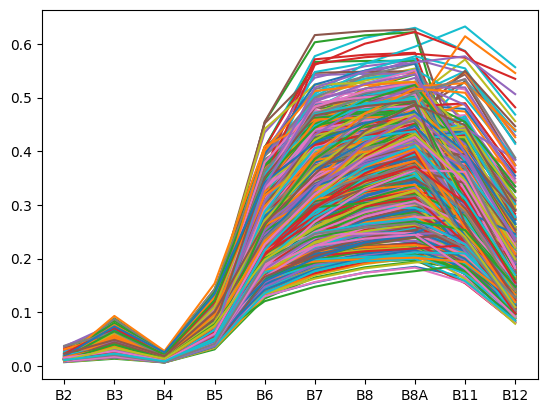

In [60]:
plt.plot(S2_sim.T);

In [61]:
meas=np.array(S2_meas)/np.mean(np.array(S2_meas))*np.mean(np.array(S2_sim))
for i in np.arange(40):
#     print(np.sum((np.array(simulated)-np.array(measured)[i,:])**2,axis=1))
    mses=np.sum((np.array(S2_sim)-meas[i,:])**2,axis=1)
    ind=np.argmin(mses)
    print(ind, mses[ind])

330 0.044779472459033215
330 0.03753991966593542
241 0.032319167736174145
330 0.033914628898315737
241 0.030437408699593712
241 0.03278873341847276
241 0.04228816105239993
241 0.038551155041294326
330 0.033990048277330334
241 0.031266911686046416
330 0.03691203863321662
241 0.039512262242352464
241 0.040294668786954604
241 0.03544398817209669
241 0.039224642264337056
241 0.04640367532089136
241 0.044608846591096596
241 0.04727212897254187
412 0.06503251811440253
241 0.0435874199356327
482 0.05305937993982368
482 0.052433616415266414
482 0.053465203098414606
330 0.042982795828091516
241 0.031618049890678644
482 0.055099915283700174
303 0.07522389923812628
241 0.04676858831160577
330 0.04182744954202543
241 0.050371874634799856
330 0.0535385722954917
330 0.04236532209274361
241 0.033765912782967034
330 0.048587869521534814
241 0.030697125492976814
241 0.03679643404031962
241 0.03682035103049601
241 0.048950405352316866
482 0.05610479259732655
330 0.04918009766000135


In [29]:
new_data_simulated = S2_sim.T
new_data_measured = S2_meas.T

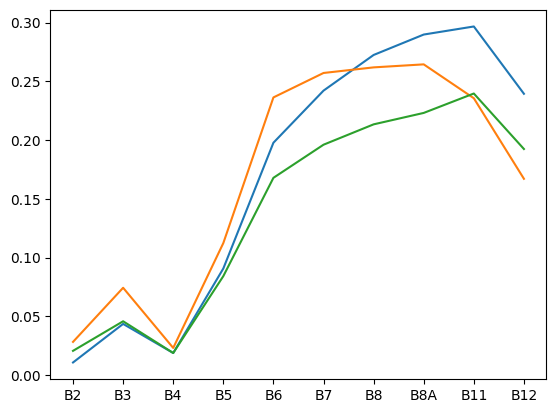

In [30]:
best_simulated = new_data_simulated[[43,990,691]]
plt.plot(best_simulated);

In [31]:
inner = pd.concat([new_data_measured, best_simulated], axis = 1)
inner

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,43,990,691
B2,955,903,855,859,842,872,919,912,868,843,...,953,851,889,891,947,983,977,0.010724,0.028251,0.020630
B3,837,795,716,742,694,726,775,760,740,700,...,830,680,759,760,816,854,846,0.043559,0.074317,0.045795
B4,750,719,636,647,623,639,737,700,638,636,...,783,595,689,688,793,825,803,0.018772,0.023104,0.018816
B5,953,924,828,853,771,800,873,830,847,791,...,950,748,854,844,920,960,936,0.090729,0.112362,0.084223
B6,1331,1296,1150,1250,1078,1104,1135,1092,1230,1113,...,1245,1025,1179,1149,1179,1202,1246,0.197786,0.236352,0.167912
B7,1498,1437,1336,1412,1231,1282,1293,1254,1409,1265,...,1426,1175,1340,1291,1345,1345,1443,0.242138,0.257167,0.196103
B8,1515,1466,1372,1438,1265,1303,1299,1269,1439,1317,...,1451,1220,1362,1309,1371,1422,1495,0.272497,0.261933,0.213435
B8A,1752,1680,1556,1657,1437,1503,1482,1470,1672,1513,...,1670,1405,1572,1507,1563,1606,1695,0.289885,0.264499,0.223167
B11,2318,1968,2035,1978,1886,2033,2201,2129,2050,2058,...,2338,1966,2079,2092,2281,2460,2328,0.296752,0.235667,0.239690
B12,1397,1215,1141,1106,1067,1173,1389,1309,1153,1176,...,1399,1113,1202,1252,1426,1542,1417,0.239462,0.167087,0.192445


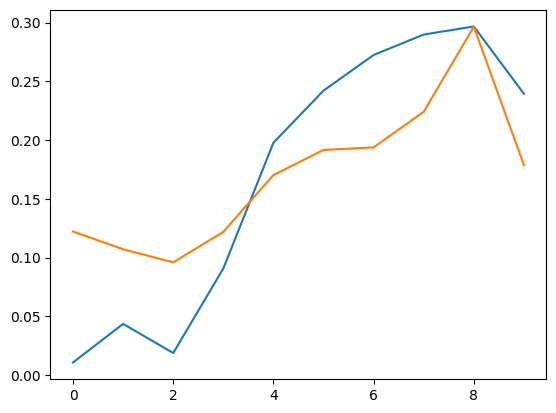

In [35]:
plt.plot(np.array(inner)[:,-3]);
plt.plot(np.array(inner)[:,0]/np.mean(np.array(inner)[:,0])*np.mean(np.array(inner)[:,-3]));

In [40]:
new = pd.DataFrame(S2_sim1, columns = (43, 990, 691, 990, 691, 691, 691, 691, 990, 691, 990, 691, 990, 691, 691, 691, 691, 691, 43, 43, 43, 43, 43, 43, 691, 43, 43, 43, 990, 43, 43, 990, 691, 43, 691, 691, 691, 43, 43, 43))

In [51]:
X_data = new.T
y_data = df_chloro

In [47]:
from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.30, random_state = 0)
from sklearn.ensemble import RandomForestRegressor
RFReg = RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1, random_state=0)
RFReg.fit(X_train, y_train)
y_pred_RFReg = RFReg.predict(X_train)
from sklearn import metrics
r_square_rf = metrics.r2_score(y_train, y_pred_RFReg)
print('r-square: ', r_square_rf)



C:\Users\BSibiya\AppData\Local\Temp\ipykernel_7412\1359165734.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFReg.fit(X_train, y_train)


r-square:  0.0722544381627539
